# HomeWork 5 Juypter Book

# Matthew Anderson | 801203905

# Github https://github.com/Mand187/IOT-ML-Tiny-ML-


This homework is primarily meant to work towards Project 2, and secondarily to explore some aspects of the regularization topics covered in class.  This is an individual assignment, even if you are doing the project in a group.  There is no code submission for this assignment, just a document describing your results.

You can use this python file Download this python fileas a starting point.  Read through the code and make sure you understand what it does.

Choose two keywords from the Google-30 dataset and build a model to detect those two words as well as a "silence" and "unknown" category.  You can use either the "mini" or "full" version of the speech commands dataset.  The mini version is smaller, so generally runs faster, but also generally gives worse results.  For this homework, you may want to use the smaller "mini" dataset, then switch to the full set when your project work is nearing its final training runs.
Start by finding a model architecture that gets you at least 80% training accuracy.  Include an English description of the model and the model.summary() output, as well as the training curves, showing 80% training accuracy and your validation accuracy.
What are the false positive and false negative rates for your two words?
Either increase the model capacity or decrease the amount of data until you see at least at 10 percentage-point difference between the training accuracy and test-set accuracy.  Describe what changes you made.
Apply both L1 and L2 kernel regularization (in two separate training runs), both with a coefficient of 0.01.  Did either of these reduce the difference between training and test accuracy?  Did either improve the test accuracy?
Measure the sparsity -- the fraction of values that are ~0 -- in each layer of each of the three resulting models, and build a table.  For this purpose, define ~0 as having an absoliute value less than 0.01x of the largest absolute value in the layer.  Discuss the results.
Limit one of your target words to 25 samples and the other to 250 samples.  Re-train and measure the FPR and FNR of both words.  Use whatever regularization you like in this step.  Describe your results and what regularization you used.
Experiment some and determine how much data you need to reach a FPR<0.2 and TPR>0.75.  Describe your results.

In [1]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow.keras import Input, layers
from tensorflow.keras import models
from tensorflow.keras import preprocessing
from tensorflow.lite.experimental.microfrontend.python.ops import audio_microfrontend_op as frontend_op
print(tf.__version__)

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

try:
    in_notebook = 'ipykernel' in sys.modules
except:
    in_notebook = False

if in_notebook:
  from tqdm.notebook import tqdm
else:
  from tqdm import tqdm 

import os, glob, pathlib, time, random

from datetime import datetime as dt
from IPython import display
import platform

2.19.0


In [2]:
# Set seed for experiment reproducibility
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

In [3]:
i16min = -2**15
i16max = 2**15-1
fsamp = 16000 # sampling rate
wave_length_ms = 1000 # 1000 => 1 sec of audio
wave_length_samps = int(wave_length_ms*fsamp/1000)

# you can change these next three
window_size_ms=64 
window_step_ms=48
num_filters = 32
batch_size = 32
use_microfrontend = True # recommended, but you can use another feature extractor if you like

## For HW5 only mini-speech dataset is needed
dataset = 'mini-speech'
# dataset = 'full-speech-files' # use the full speech commands stored as files 

commands = ['down', 'stop'] ## Change this line for your custom keywords

# limit the instances of each command in the training set to simulate limited data
limit_positive_samples = True
max_wavs_0 = 50  # use no more than ~ samples of commands[0]
max_wavs_1 = 250  # use no more than ~ samples of commands[1]

silence_str = "_silence"  # label for <no speech detected>
unknown_str = "_unknown"  # label for <speech detected but not one of the target words>
EPOCHS = 5

print(f"FFT window length = {int(window_size_ms * fsamp / 1000)}")

might_be = {True:"IS", False:"IS NOT"} # useful for formatting conditional sentences

FFT window length = 1024


In [4]:
home_dir = os.getcwd()

if dataset == 'mini-speech':
  data_dir = pathlib.Path(os.path.join(home_dir, 'data', 'mini_speech_commands'))
  if not data_dir.exists():
    tf.keras.utils.get_file('mini_speech_commands.zip',
          origin="http://storage.googleapis.com/download.tensorflow.org/data/mini_speech_commands.zip",
          extract=True, cache_dir='.', cache_subdir='data'
                           )
  # commands = np.array(tf.io.gfile.listdir(str(data_dir))) # if you want to use all the command words
  # commands = commands[commands != 'README.md']
elif dataset == 'full-speech-files':
  data_dir = pathlib.Path(os.path.join(home_dir, 'data', 'speech_commands_v0.02'))
  if not data_dir.exists():
    raise RuntimeError(f"Either download the speech commands files to {data_dir} or change this code to where you have them")
else:
  raise RuntimeError('dataset should either be "mini-speech" or "full-speech-files"')

In [5]:
label_list = commands.copy()
label_list.insert(0, silence_str)
label_list.insert(1, unknown_str)
print('label_list:', label_list)

label_list: ['_silence', '_unknown', 'down', 'stop']


In [6]:
if dataset in ['mini-speech', 'full-speech-files']:
    filenames = glob.glob(os.path.join(str(data_dir), '*', '*.wav')) 
  
    random.shuffle(filenames)
    num_samples = len(filenames)
    print('Number of total examples:', num_samples)
    # print('Number of examples per label:',
    #       len(tf.io.gfile.listdir(str(data_dir/commands[0]))))
    if num_samples > 0:
        print('Directory of audio files:', data_dir)
        print('Number of audio files:', len(filenames))
        print('Example file tensor:', filenames[0])
    else:
        print('Directory Looked at:', data_dir)
        print('No audio files found in the specified directory.')

Number of total examples: 8000
Directory of audio files: c:\Users\Matt\OneDrive\Documents\Github-IOT-ML-Tiny-ML-\HW5\data\mini_speech_commands
Number of audio files: 8000
Example file tensor: c:\Users\Matt\OneDrive\Documents\Github-IOT-ML-Tiny-ML-\HW5\data\mini_speech_commands\stop\f06190c1_nohash_1.wav


In [7]:
if dataset == 'mini-speech':
  print('Using mini-speech')
  num_train_files = int(0.8*num_samples) 
  num_val_files = int(0.1*num_samples) 
  num_test_files = num_samples - num_train_files - num_val_files
  train_files = filenames[:num_train_files]
  val_files = filenames[num_train_files: num_train_files + num_val_files]
  test_files = filenames[-num_test_files:]
elif dataset == 'full-speech-files':  
  # the full speech-commands set lists which files are to be used
  # as test and validation data; train with everything else
  fname_val_files = os.path.join(data_dir, 'validation_list.txt')
  with open(fname_val_files) as fpi_val:
    val_files = fpi_val.read().splitlines()
  # validation_list.txt only lists partial paths
  val_files = [os.path.join(data_dir, fn) for fn in val_files]
  fname_test_files = os.path.join(data_dir, 'testing_list.txt')
  with open(fname_test_files) as fpi_tst:
    test_files = fpi_tst.read().splitlines()
  # testing_list.txt only lists partial paths
  test_files = [os.path.join(data_dir, fn).rstrip() for fn in test_files]    
    
  if os.sep != '/': 
    # the files validation_list.txt and testing_list.txt use '/' as path separator
    # if we're on a windows machine, replace the '/' with the correct separator
    val_files = [fn.replace('/', os.sep) for fn in val_files]
    test_files = [fn.replace('/', os.sep) for fn in test_files] 

  # convert the TF tensor filenames into an array of strings so we can use basic python constructs
  # train_files = [f.decode('utf8') for f in filenames.numpy()]

  
  # don't train with the _background_noise_ files; exclude when directory name starts with '_'
  train_files = [f for f in filenames if f.split(os.sep)[-2][0] != '_']
  # validation and test files are listed explicitly in *_list.txt; train with everything else
  train_files = list(set(train_files) - set(test_files) - set(val_files))
   
elif dataset == 'full-speech-ds':  
    print("Using full-speech-ds. This is in progress.  Good luck!")
else:
  raise ValueError("dataset must be either full-speech-files, full-speech-ds or mini-speech")
print('Training set size', len(train_files))
print('Validation set size', len(val_files))
print('Test set size', len(test_files))


Using mini-speech
Training set size 6400
Validation set size 800
Test set size 800


In [8]:
## Remove some of the target words if we're experimenting with limited data

if limit_positive_samples:
  if dataset not in ['mini-speech', 'full-speech-files']:
    raise RuntimeError("Right now, limit_positive_samples is only implemented if drawing the data from files")
  num_files_cmd0 = 0
  num_files_cmd1 = 0
  # elements of train_files look like this:
  # '/path/to/data/speech_commands_0_2_root/right/196e84b7_nohash_0.wav'
  # so if we split on '/' (or '\' in windows), the 2nd to last element is the label
  for idx,f in enumerate(train_files):
    if f.split(os.sep)[-2] == commands[0]:
      if num_files_cmd0 >= max_wavs_0:
        train_files.pop(idx)
      else:
        num_files_cmd0 += 1
    elif f.split(os.sep)[-2] == commands[1]:
      if num_files_cmd1 >= max_wavs_1:
        train_files.pop(idx)
      else:
        num_files_cmd1 += 1

In [9]:
print(train_files[:5])
print(val_files[:5])
print(test_files[:5])

['c:\\Users\\Matt\\OneDrive\\Documents\\Github-IOT-ML-Tiny-ML-\\HW5\\data\\mini_speech_commands\\stop\\f06190c1_nohash_1.wav', 'c:\\Users\\Matt\\OneDrive\\Documents\\Github-IOT-ML-Tiny-ML-\\HW5\\data\\mini_speech_commands\\right\\b0bad4a9_nohash_1.wav', 'c:\\Users\\Matt\\OneDrive\\Documents\\Github-IOT-ML-Tiny-ML-\\HW5\\data\\mini_speech_commands\\down\\106a6183_nohash_3.wav', 'c:\\Users\\Matt\\OneDrive\\Documents\\Github-IOT-ML-Tiny-ML-\\HW5\\data\\mini_speech_commands\\up\\b93528e3_nohash_0.wav', 'c:\\Users\\Matt\\OneDrive\\Documents\\Github-IOT-ML-Tiny-ML-\\HW5\\data\\mini_speech_commands\\no\\2e0d80f7_nohash_2.wav']
['c:\\Users\\Matt\\OneDrive\\Documents\\Github-IOT-ML-Tiny-ML-\\HW5\\data\\mini_speech_commands\\stop\\620ff0fa_nohash_0.wav', 'c:\\Users\\Matt\\OneDrive\\Documents\\Github-IOT-ML-Tiny-ML-\\HW5\\data\\mini_speech_commands\\down\\bd061bef_nohash_1.wav', 'c:\\Users\\Matt\\OneDrive\\Documents\\Github-IOT-ML-Tiny-ML-\\HW5\\data\\mini_speech_commands\\up\\bdee441c_nohash_3.w

In [10]:
def decode_audio(audio_binary):
    audio, _ = tf.audio.decode_wav(audio_binary)
    return tf.squeeze(audio, axis=-1)  # optional: remove channels dimension if 1D

def get_waveform_and_label(file_path):
    label = get_label(file_path)
    audio_binary = tf.io.read_file(file_path)
    waveform = decode_audio(audio_binary)
    return waveform, label

def get_label(file_path):
  parts = tf.strings.split(file_path, os.path.sep)
  in_set = tf.reduce_any(parts[-2] == label_list)
  label = tf.cond(in_set, lambda: parts[-2], lambda: tf.constant(unknown_str))
  # print(f"parts[-2] = {parts[-2]}, in_set = {in_set}, label = {label}")
  # Note: You'll use indexing here instead of tuple unpacking to enable this 
  # to work in a TensorFlow graph.
  return  label # parts[-2]


def get_spectrogram(waveform):
  # Concatenate audio with padding so that all audio clips will be of the 
  # same length (16000 samples)
  zero_padding = tf.zeros([wave_length_samps] - tf.shape(waveform), dtype=tf.int16)
  waveform = tf.cast(0.5*waveform*(i16max-i16min), tf.int16)  # scale float [-1,+1]=>INT16
  equal_length = tf.concat([waveform, zero_padding], 0)
  ## Make sure these labels correspond to those used in micro_features_micro_features_generator.cpp
  spectrogram = frontend_op.audio_microfrontend(equal_length, sample_rate=fsamp, num_channels=num_filters,
                                    window_size=window_size_ms, window_step=window_step_ms)
  return spectrogram


# Function to convert each waveform in a set into a spectrogram, then convert those
# back into a dataset using `from_tensor_slices`.  (We should be able to use 
# `wav_ds.map(get_spectrogram_and_label_id)`, but there is a problem with that process).
#    


def create_silence_dataset(num_waves, samples_per_wave, rms_noise_range=[0.01,0.2], silent_label=silence_str):
    # create num_waves waveforms of white gaussian noise, with rms level drawn from rms_noise_range
    # to act as the "silence" dataset
    rng = np.random.default_rng()
    rms_noise_levels = rng.uniform(low=rms_noise_range[0], high=rms_noise_range[1], size=num_waves)
    rand_waves = np.zeros((num_waves, samples_per_wave), dtype=np.float32) # pre-allocate memory
    for i in range(num_waves):
        rand_waves[i,:] = rms_noise_levels[i]*rng.standard_normal(samples_per_wave)
    labels = [silent_label]*num_waves
    return tf.data.Dataset.from_tensor_slices((rand_waves, labels))  

def wavds2specds(waveform_ds, verbose=True):
  wav, label = next(waveform_ds.as_numpy_iterator())
  one_spec = get_spectrogram(wav)
  one_spec = tf.expand_dims(one_spec, axis=0)  # add a 'batch' dimension at the front
  one_spec = tf.expand_dims(one_spec, axis=-1) # add a singleton 'channel' dimension at the back    

  num_waves = 0 # count the waveforms so we can allocate the memory
  for wav, label in waveform_ds:
    num_waves += 1
  print(f"About to create spectrograms from {num_waves} waves")
  spec_shape = (num_waves,) + one_spec.shape[1:] 
  spec_grams = np.nan * np.zeros(spec_shape)  # allocate memory
  labels = np.nan * np.zeros(num_waves)
  idx = 0
  for wav, label in waveform_ds:    
    if verbose and idx % 250 == 0:
      print(f"\r {idx} wavs processed", end='')
    spectrogram = get_spectrogram(wav)
    # TF conv layer expect inputs structured as 4D (batch_size, height, width, channels)
    # the microfrontend returns 2D tensors (freq, time), so we need to 
    spectrogram = tf.expand_dims(spectrogram, axis=0)  # add a 'batch' dimension at the front
    spectrogram = tf.expand_dims(spectrogram, axis=-1) # add a singleton 'channel' dimension at the back
    spec_grams[idx, ...] = spectrogram
    new_label = label.numpy().decode('utf8')
    new_label_id = np.argmax(new_label == np.array(label_list))    
    labels[idx] = new_label_id # for numeric labels
    # labels.append(new_label) # for string labels
    idx += 1
  labels = np.array(labels, dtype=int)
  output_ds = tf.data.Dataset.from_tensor_slices((spec_grams, labels))  
  return output_ds

def copy_with_noise(ds_input, rms_level=0.25):
  rng = tf.random.Generator.from_seed(1234)
  wave_shape = tf.constant((wave_length_samps,))
  def add_noise(waveform, label):
    noise = rms_level*rng.normal(shape=wave_shape)
    zero_padding = tf.zeros([wave_length_samps] - tf.shape(waveform), dtype=tf.float32)
    waveform = tf.concat([waveform, zero_padding], 0)    
    noisy_wave = waveform + noise
    return noisy_wave, label

  return ds_input.map(add_noise)


def pad_16000(waveform, label):
    zero_padding = tf.zeros([wave_length_samps] - tf.shape(waveform), dtype=tf.float32)
    waveform = tf.concat([waveform, zero_padding], 0)        
    return waveform, label

def count_labels(dataset):
    counts = {}
    for sample in dataset: # sample will be a tuple: (input, label) or (input, label, weight)
        lbl = sample[1]
        if lbl.dtype == tf.string:
            label = lbl.numpy().decode('utf-8')
        else:
            label = lbl.numpy()
        if label in counts:
            counts[label] += 1
        else:
            counts[label] = 1
    return counts

def is_batched(ds):
    ## This is probably not very robust
    try:
        ds.unbatch()  # does not actually change ds. For that we would ds=ds.unbatch()
    except:
        return False # we'll assume that the error on unbatching is because the ds is not batched.
    else:
        return True  # if we were able to unbatch it then it must have been batched (??)
    

# Collect what we did to generate the training dataset into a 
# function, so we can repeat with the validation and test sets.
def preprocess_dataset(files, num_silent=None, noisy_reps_of_known=None):
  """
  preprocess_dataset(files, num_silent=None, noisy_reps_of_known=None)
  files -- list of files
  noisy_reps_of_known either None, or a list of rms noise levels
      For every target word in the data set, 1 copy will be created with each level 
      of noise added to it.  So [0.1, 0.2] will add 2x noisy copies of the target words 
  """
  if num_silent is None:
    num_silent = int(0.2*len(files))+1
  print(f"Processing {len(files)} files")
  files_ds = tf.data.Dataset.from_tensor_slices(files)
  waveform_ds = files_ds.map(get_waveform_and_label)
  if noisy_reps_of_known is not None:
    # create a few copies of only the target words to balance the distribution
    # create a tmp dataset with only the target words
    ds_only_cmds = waveform_ds.filter(lambda w,l: tf.reduce_any(l == commands))
    for noise_level in noisy_reps_of_known:
       waveform_ds = waveform_ds.concatenate(copy_with_noise(ds_only_cmds, rms_level=noise_level))
  if num_silent > 0:
    silent_wave_ds = create_silence_dataset(num_silent, wave_length_samps, 
                                            rms_noise_range=[0.01,0.2], 
                                            silent_label=silence_str)
    waveform_ds = waveform_ds.concatenate(silent_wave_ds)
  print(f"Added {num_silent} silent wavs and ?? noisy wavs")
  num_waves = 0
  output_ds = wavds2specds(waveform_ds)
  return output_ds


In [11]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
num_train_files = len(train_files)
files_ds = tf.data.Dataset.from_tensor_slices(train_files)
waveform_ds = files_ds.map(get_waveform_and_label, num_parallel_calls=AUTOTUNE)
train_ds = wavds2specds(waveform_ds)

print(f"We have {len(train_files)}/{len(val_files)}/{len(test_files)} training/validation/test files")

# train_files = train_files[0:10000] for a quick test run


About to create spectrograms from 5364 waves
 5250 wavs processedWe have 5364/800/800 training/validation/test files


In [12]:
t0 = time.time()
# train_ds is already done
with tf.device('/CPU:0'): # needed on M1 mac
    train_ds = preprocess_dataset(train_files, noisy_reps_of_known=[0.05,0.1,0.15,0.2,0.25, .1, .1, .1])

val_ds = preprocess_dataset(val_files)
test_ds = preprocess_dataset(test_files)
t1 = time.time()
print(f"Took time: {t1-t0}")

Processing 5364 files
Added 1073 silent wavs and ?? noisy wavs
About to create spectrograms from 10813 waves
 10750 wavs processedProcessing 800 files
Added 161 silent wavs and ?? noisy wavs
About to create spectrograms from 961 waves
 750 wavs processedProcessing 800 files
Added 161 silent wavs and ?? noisy wavs
About to create spectrograms from 961 waves
 750 wavs processedTook time: 20.9588680267334


In [13]:
train_ds = train_ds.shuffle(int(len(train_files)*1.2))
val_ds = val_ds.shuffle(int(len(val_files)*1.2))
test_ds = test_ds.shuffle(int(len(test_files)*1.2))


In [14]:
if not is_batched(train_ds):
    train_ds = train_ds.batch(batch_size)
if not is_batched(val_ds):
    val_ds = val_ds.batch(batch_size)
if not is_batched(test_ds):
    test_ds = test_ds.batch(batch_size)

train_ds = train_ds.cache().prefetch(AUTOTUNE)
val_ds = val_ds.cache().prefetch(AUTOTUNE)

In [15]:
for spectrogram, _ in train_ds.take(1):
  # take(1) takes 1 *batch*, so we have to select the first 
  # spectrogram from it, hence the [0]
  input_shape = spectrogram.shape[1:]  
print('Input shape:', input_shape)
num_labels = len(label_list)

Input shape: (20, 32, 1)


In [16]:
def build_model(input_shape):
    model = models.Sequential([
        layers.Input(shape=input_shape),
        layers.Conv2D(32, 3, activation='relu'),
        layers.MaxPooling2D(pool_size=(1,2)),
        layers.BatchNormalization(),
      
        layers.Conv2D(64, 3, activation='relu'),
        layers.BatchNormalization(),
      
        layers.Conv2D(128, 3, activation='relu'),
        layers.BatchNormalization(),

        layers.Conv2D(256, 3, activation='relu'),
        layers.BatchNormalization(),
      
        layers.Conv2D(256, 3, activation='relu'),
        layers.BatchNormalization(),
      
        layers.GlobalMaxPooling2D(),
        layers.Dense(num_labels),
    ])
    model.compile(
        optimizer=tf.keras.optimizers.Adam(),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=['accuracy'],
    )
    return model

In [17]:
print('Input shape:', input_shape)
model = build_model(input_shape)
model.summary()   

Input shape: (20, 32, 1)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 18, 30, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 18, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 18, 15, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 16, 13, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 16, 13, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 14, 11, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 14, 11, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 12, 9, 256)     │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 12, 9, 256)     │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 10, 7, 256)     │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 10, 7, 256)     │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling2d            │ (None, 256)            │             0 │
│ (GlobalMaxPooling2D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 981,892 (3.75 MB)

 Trainable params: 980,420 (3.74 MB)

 Non-trainable params: 1,472 (5.75 KB)

In [28]:
history = model.fit(
    train_ds, 
    validation_data=val_ds,  
    epochs=EPOCHS) 

date_str = dt.now().strftime("%d%b%Y_%H%M").lower()
print(f"Completed training at {date_str}")

Epoch 1/5
338/338 ━━━━━━━━━━━━━━━━━━━━ 9s 26ms/step - accuracy: 0.9825 - loss: 0.0514 - val_accuracy: 0.9355 - val_loss: 0.3186
Epoch 2/5
338/338 ━━━━━━━━━━━━━━━━━━━━ 10s 29ms/step - accuracy: 0.9913 - loss: 0.0297 - val_accuracy: 0.8283 - val_loss: 0.6365
Epoch 3/5
338/338 ━━━━━━━━━━━━━━━━━━━━ 10s 29ms/step - accuracy: 0.9904 - loss: 0.0295 - val_accuracy: 0.8106 - val_loss: 1.3714
Epoch 4/5
338/338 ━━━━━━━━━━━━━━━━━━━━ 10s 29ms/step - accuracy: 0.9855 - loss: 0.0473 - val_accuracy: 0.9240 - val_loss: 0.4339
Epoch 5/5
338/338 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step - accuracy: 0.9928 - loss: 0.0217 - val_accuracy: 0.9261 - val_loss: 0.3596
Completed training at 14apr2025_0924


In [29]:
if 'model' in globals():
	model_file_name = f"kws_model.h5" 
	print(f"Saving model to {model_file_name}")
	model.save(model_file_name, overwrite=True)
else:
	print("Error: 'model' is not defined. Please ensure the cell defining the model is executed.")

Saving model to kws_model.h5


In [30]:
## Measure test-set accuracy manually and get values for confusion matrix
test_audio = []
test_labels = []
if is_batched(test_ds):
  was_batched=True
  test_ds = test_ds.unbatch()
else:
  was_batched=False
for audio, label in test_ds:
  test_audio.append(audio.numpy())
  test_labels.append(label.numpy())

test_audio = np.array(test_audio)
test_labels = np.array(test_labels)

model_out = model.predict(test_audio)
y_pred = np.argmax(model_out, axis=1)
y_true = test_labels

test_acc = sum(y_pred == y_true) / len(y_true)
print(f'Test set accuracy: {test_acc:.1%}')
if was_batched:
  test_ds = test_ds.batch(32)

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
Test set accuracy: 92.8%


In [31]:
## Measure test-set accuracy with the keras built-in function
test_loss, test_acc = model.evaluate(test_ds, verbose=2)


31/31 - 0s - 8ms/step - accuracy: 0.9282 - loss: 0.3279


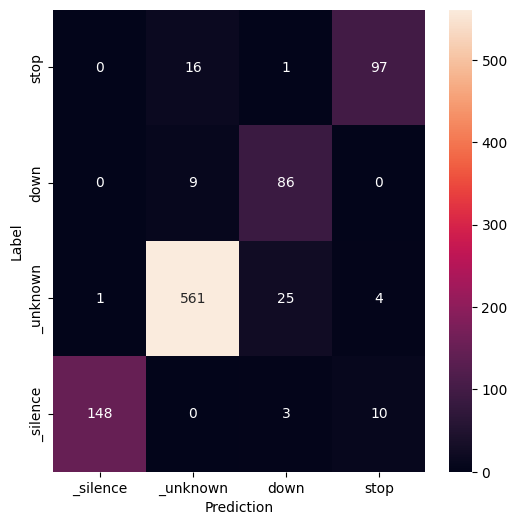

In [32]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred) 
plt.figure(figsize=(6, 6))
sns.heatmap(confusion_mtx, xticklabels=label_list, yticklabels=label_list, 
            annot=True, fmt='g')
plt.gca().invert_yaxis() # flip so origin is at bottom left
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

In [33]:
tpr = np.nan * np.zeros(len(label_list))
fpr = np.nan * np.zeros(len(label_list))

for i in range(4):
  tpr[i] = confusion_mtx[i, i] / np.sum(confusion_mtx[i, :])
  fpr[i] = (np.sum(confusion_mtx[:, i]) - confusion_mtx[i, i]) / \
       (np.sum(confusion_mtx) - np.sum(confusion_mtx[i, :]))
  print(f"True Positive Rate (TPR) for '{label_list[i]:9}': {tpr[i]:.3}")
  print(f"False Positive Rate (FPR) for '{label_list[i]:9}': {fpr[i]:.3}")
  print()

True Positive Rate (TPR) for '_silence ': 0.919
False Positive Rate (FPR) for '_silence ': 0.00125

True Positive Rate (TPR) for '_unknown ': 0.949
False Positive Rate (FPR) for '_unknown ': 0.0676

True Positive Rate (TPR) for 'down     ': 0.905
False Positive Rate (FPR) for 'down     ': 0.0335

True Positive Rate (TPR) for 'stop     ': 0.851
False Positive Rate (FPR) for 'stop     ': 0.0165



In [34]:
info_file_name = model_file_name.split('.')[0] + '.txt'
with open(info_file_name, 'w') as fpo:
    fpo.write(f"i16min            = {i16min           }\n")
    fpo.write(f"i16max            = {i16max           }\n")
    fpo.write(f"fsamp             = {fsamp            }\n")
    fpo.write(f"wave_length_ms    = {wave_length_ms   }\n")
    fpo.write(f"wave_length_samps = {wave_length_samps}\n")
    fpo.write(f"window_size_ms    = {window_size_ms   }\n")
    fpo.write(f"window_step_ms    = {window_step_ms   }\n")
    fpo.write(f"num_filters       = {num_filters      }\n")
    fpo.write(f"use_microfrontend = {use_microfrontend}\n")
    fpo.write(f"label_list        = {label_list}\n")
    fpo.write(f"spectrogram_shape = {spectrogram.numpy().shape}\n")
    fpo.write(f"Test set accuracy =  {test_acc:.1%}\n")
    for i in range(4):
        fpo.write(f"tpr_{label_list[i]:9} = {tpr[i]:.3}\n")
        fpo.write(f"fpr_{label_list[i]:9} = {fpr[i]:.3}\n")

In [35]:
print(f"Wrote description to {info_file_name}")
get_ipython().system('type {info_file_name}')

Wrote description to kws_model.txt
i16min            = -32768
i16max            = 32767
fsamp             = 16000
wave_length_ms    = 1000
wave_length_samps = 16000
window_size_ms    = 64
window_step_ms    = 48
num_filters       = 32
use_microfrontend = True
label_list        = ['_silence', '_unknown', 'down', 'stop']
spectrogram_shape = (32, 20, 32, 1)
Test set accuracy =  92.8%
tpr__silence  = 0.919
fpr__silence  = 0.00125
tpr__unknown  = 0.949
fpr__unknown  = 0.0676
tpr_down      = 0.905
fpr_down      = 0.0335
tpr_stop      = 0.851
fpr_stop      = 0.0165


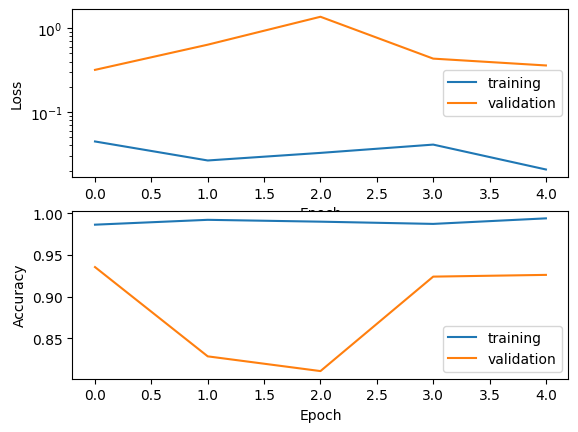

<Figure size 640x480 with 0 Axes>

In [36]:
metrics = history.history
plt.subplot(2,1,1)
plt.semilogy(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['training', 'validation'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.subplot(2,1,2)
plt.plot(history.epoch, metrics['accuracy'], metrics['val_accuracy'])
plt.legend(['training', 'validation'])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.show()
plt.savefig('training_curves.png')

In [37]:
## Measure test-set accuracy with the keras built-in function
test_loss, test_acc = model.evaluate(test_ds, verbose=2)

31/31 - 0s - 8ms/step - accuracy: 0.9282 - loss: 0.3279


C:\Users\Matt\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\trainers\epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()
